In [1]:
import cv2
import numpy as np
import sys
import os

import matplotlib.pyplot as plt
import pandas as pd

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
def get_pair(img_no):
    radio_path = f"data/train/Healthy/Radiographs/Image ({img_no}).jpg"
    mask_path = f"data/train/Healthy/Masks/Image ({img_no}).jpg"
    radio = cv2.imread(radio_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return radio, mask

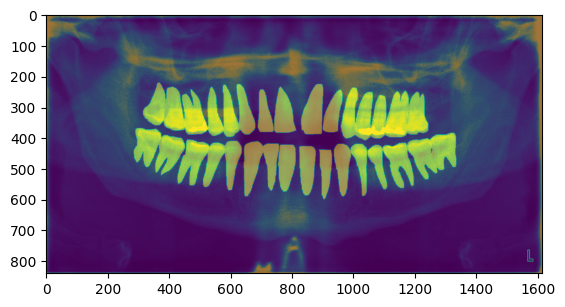

In [3]:
radio, mask = get_pair(7)
plt.imshow(radio)
plt.imshow(mask, alpha=0.5)
plt.show()

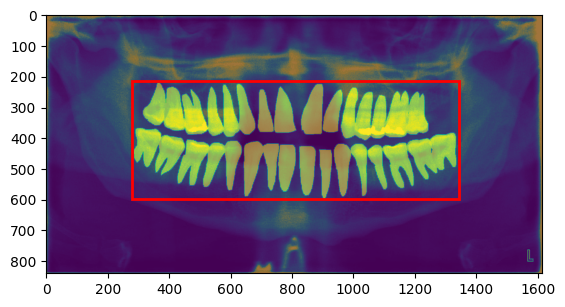

In [4]:
radio, mask = get_pair(7)

mask_indices = np.argwhere(mask)
(ymin, xmin) = mask_indices.min(axis=0)
(ymax, xmax) = mask_indices.max(axis=0)

plt.imshow(radio)
plt.imshow(mask, alpha=0.5)
plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='red', facecolor='none', lw=2))
plt.show()

In [5]:
def get_bounding_box(mask):
    mask_indices = np.argwhere(mask)
    if len(mask_indices) == 0:
        return None
    ymin, xmin = mask_indices.min(axis=0)
    ymax, xmax = mask_indices.max(axis=0)
    return [ymin, xmin, ymax, xmax]

def plot_bounding_box_with_points(image, mask):
    bbox = get_bounding_box(mask)
    top, left, bottom, right = bbox

    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.gca().add_patch(plt.Rectangle((left, top), right - left, bottom - top, edgecolor='red', facecolor='none', lw=2))
    plt.plot(left, top, 'go')
    plt.plot(right, bottom, 'go')

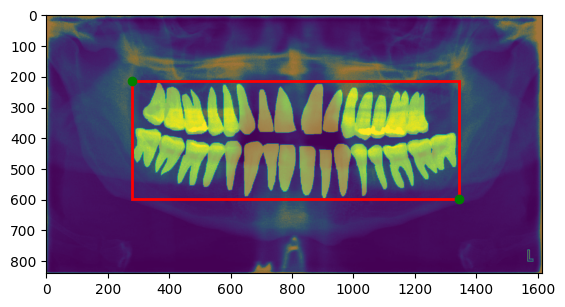

In [6]:
plot_bounding_box_with_points(radio, mask)

In [7]:
def load_data(type_):
    train_dir = "data/train/"
    classes = ['Anodontia', 'Healthy', 'Hyperdontia', 'Hypodontia', 'Oligodontia']
    class_dirs = [f"data/{type_}/{c}" for c in classes]
    for class_dir in class_dirs:
        masks = os.listdir(class_dir + "/Masks/")
        imgs = os.listdir(class_dir + "/Radiographs/")

        for mask_path, img_path in zip(masks, imgs):
            full_mask_path = class_dir + "/Masks/" + mask_path
            full_img_path = class_dir + "/Radiographs/" + img_path
            mask = cv2.imread(full_mask_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.imread(full_img_path, cv2.IMREAD_GRAYSCALE)
            yield img, mask, full_img_path

In [8]:
def get_final_set(type_):
    # train_data = list(load_data("train"))
    data = list(load_data(type_))

    df = pd.DataFrame(data, columns=["image", "mask", "path"])

    assert df.isna().sum().sum() == 0, "There are missing values in the dataframe!"

    df["bounding_box"] = df["mask"].map(get_bounding_box)

    # df.dropna(inplace=True, axis=0)

    return df

In [9]:
train_df = get_final_set("train")
valid_df = get_final_set("valid")
test_df = get_final_set("test")

In [22]:
all_data = {
    "train": train_df,
    "valid": valid_df,
    "test": test_df
}

for name, df in all_data.items():
    df: pd.DataFrame = df
    df.to_pickle(f"{name}.pkl")

In [13]:
test_df

,image,mask,path,bounding_box
0,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",data/test/Anodontia/Radiographs/Image (829).JPG,None
1,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",data/test/Anodontia/Radiographs/Image (823).JPG,None
2,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",data/test/Anodontia/Radiographs/Image (857).JPG,None
3,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",data/test/Anodontia/Radiographs/Image (846).JPG,"[576, 720, 697, 863]"
4,"[[250, 250, 250, 250, 250, 250, 250, 250, 250,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",data/test/Healthy/Radiographs/Image (873).JPG,"[200, 416, 647, 1207]"
...,...,...,...,...
85,"[[255, 255, 254, 253, 253, 253, 253, 254, 255,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",data/test/Oligodontia/Radiographs/Image (841).JPG,"[184, 576, 599, 1063]"
86,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",data/test/Oligodontia/Radiographs/Image (837).JPG,"[152, 576, 623, 1031]"
87,"[[254, 254, 254, 254, 254, 254, 254, 254, 253,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",data/test/Oligodontia/Radiographs/Image (856).JPG,"[248, 432, 679, 1223]"
88,"[[248, 248, 248, 248, 248, 248, 248, 248, 248,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",data/test/Oligodontia/Radiographs/Image (885).JPG,"[240, 312, 663, 1287]"
